<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Домашка 6: классификация

Давайте попрбобуем построить модель, предсказывающую пол пользователя

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
# Метрики для измерения качества алгоритмов 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

# 1. Снова подгружаем данные

В очередной раз подгрузим немного данных. 

In [10]:
df = pd.read_csv('../data/vk_download/vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


In [11]:
df.columns

Index(['city', 'country', 'first_name', 'home_town', 'in_hse_memes_group',
       'is_bmm', 'is_closed', 'last_name', 'likes_memes', 'uid', 'male_dummy',
       'facebook_dummy', 'instagram_dummy', 'skype_dummy', 'twitter_dummy',
       'home_phone_dummy', 'mobile_phone_dummy', 'site_dummy',
       'can_post_dummy', 'can_see_all_posts_dummy', 'can_see_audio_dummy',
       'can_write_private_message_dummy', 'has_mobile_dummy', 'has_ava_dummy',
       'wall_comments_dummy', 'english_dummy', 'folowers_cnt', 'albums_cnt',
       'audio_cnt', 'followers_cnt', 'friends_cnt', 'gifts_cnt', 'groups_cnt',
       'photos_cnt', 'subscriptions_cnt', 'user_photos_cnt', 'videos_cnt',
       'pages_cnt', 'lang_cnt', 'change_city_school_cnt', 'schools_cnt',
       'relation_cat', 'alco_love_cat', 'smoke_love_cat', 'life_main_cat',
       'people_main_cat', 'political_cat', 'private_prof_dummy',
       'wall_can_comment_dummy', 'wall_comment_cnt', 'wall_comment_max',
       'wall_comment_mean', 'wall_co

Ровно также, как мы это делали на семинаре, предобработаем данные. Если вы не понимаете какую-то из строчек в следущем большом кодище, выясните как она работает. Напишите в чат тех-поддержки, семинаристу, сходите к гадалке. Сделайте хоть что-то, потому что скоро такой код вам придётся писать самостоятельно. 

In [12]:
# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные в том числе наш указатель пола
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

#ПРОПУЩЕННАЯ СТРОЧКА
useful_variables.remove('male_dummy')


# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,first_name,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Александра,True,True,False,Абашкова,60.0,182152789,0,0,1,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.761200,0.428571
1,Анастасия,True,True,False,Чуфистова,0.0,148020433,0,0,0,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,3.496508,0.281250
2,Александр,False,True,False,Головачев,0.0,138413935,1,0,1,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.496508,0.406250
3,Анна,False,True,False,Лобанова,0.0,366261055,0,0,0,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.828641,0.333333
4,Алексей,True,True,False,Пузырный,21.0,111252392,1,0,0,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.737670,0.341463


In [15]:
df.dropna(subset=['male_dummy'], inplace=True)
# правило хорошего тона, но у нас в этомстолбце нет пропусков,  можно за такое не карать

# 2. Подготовка к моделированию.

Начнём с простого. 

__[1]__ Разделите выборку на тренировочную и тестовую. Запишите обучающую выборку в табличку `df_train`, а тестовую в `df_test`.

In [16]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 

Для удобства запишем в `y` то, что мы хотим прогнозировать.

In [18]:
y_train = df_train['male_dummy'].values
y_test = df_test['male_dummy'].values

Посмотрим как соотносятся доли парней и девушек в тренировочной и тестовой выборках.

In [19]:
np.mean(y_train), np.mean(y_test)

(0.46176470588235297, 0.4470588235294118)

В `X` запишем то, по чему мы будем прогнозировать. 

In [21]:
# Забираем в выборку лучших из лучших 
X_train = df_train[useful_variables].values
X_test = df_test[useful_variables].values

# 3. Метод ближайшего соседа

Начнём моделирование с метода ближайшего соседа. 

__[1]__ Проскалируйте переменные. Поясните в виде текста зачем нужно это делать. Надо ли скалировать переменные для деревьев? 

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler( )
scaler.fit(X_train) 

X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

__[1]__ Обучите на тренировочной выборке алгоритм 10 ближайших соседей. Запишите прогнозы алгоритма в переменную `y_predict`.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_norm, y_train)
y_predict = knn.predict_proba(X_test_norm)[:,-1] 
# если просто предикт и потом строят по бинарному предсказанию картинку, то этохрень. Это заметно по форме кривой

Построим для получившегося алгоритма roc-кривую на тестовой выборке. 

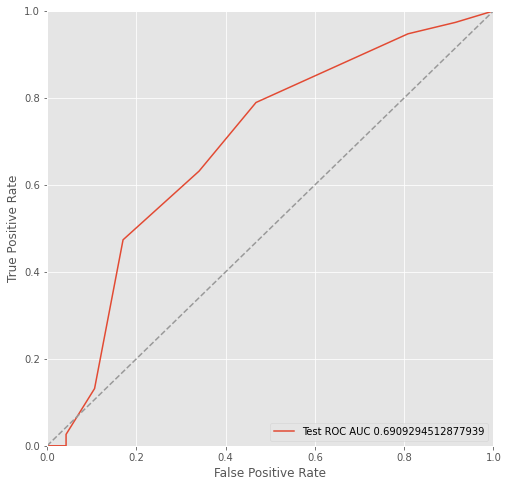

In [25]:
# Для леса
roc_auc_pic(y_predict, y_test)

Посмотрим какой получилось accuracy (доля правильных ответов). 

In [26]:

y_predict = knn.predict(X_test_norm) # а тут уже надо именнопредсказание класса брать 
accuracy_score(y_test, y_predict)

0.6705882352941176

__[1]__ Какой вывод о прогнозной силе алгоритма вы можете сделать? Можно ли в данной ситуации в качестве метрики использовать `acuracy`? 

__Ответ:__ 

# 4. Пытаемся улучшить работу алгоритма

Давайте попытаемся выжать из метода ближайших соседей максимум. 

__[2]__ Попробуйте перебрать разное количество соседей и разные дистанции. Насколько получилось улучшить работу классификатора? 

In [28]:
# Ваш код
# Решётка для перебора 
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(5, 16),         # число соседей от 5 до 15
     'weights':['uniform', 'distance'],  # надо ли более близких соседей учитывать с большим весом
     'metric':['euclidean', 'manhattan', 'chebyshev']} #разные способы измерения расстояний

# объявили модель
knn_clf = KNeighborsClassifier()

# завернули её в решётку для поиска параметров
grid_knn = GridSearchCV(knn_clf, parameters, cv=3, scoring="roc_auc")

# обучаем нашу решётку (если мы хотим перебрать много параметров, обучение будет идти долго) 
grid_knn.fit(X_train_norm, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 16), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'chebyshev']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Какое сочетания параметров оказалось оптимальным? Какое качество показывает алгоритм? 

In [29]:
grid_knn.best_score_

0.6731417592614624

In [30]:
grid_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}

# 5. Дерево 

__[2]__ Продолжаем наше путешествие в классификацию. Постройте решающее дерево. Какое качество оно показывает на тренировочной выборке? А на тестовой? Что такое переобучение? Правда ли, что дерево переобучилось? 

In [31]:
# Ваш код
# Подшружаем дерево 
from sklearn.tree import DecisionTreeClassifier

# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train_norm, y_train)

# предсказываем на обучающей выборке результат
y_predicted = tree.predict(X_train_norm)
p_predicted = tree.predict_proba(X_train_norm)[:,-1]

# качество на трэйне 
print('accuracy:', accuracy_score(y_train, y_predicted))
print('roc_auc:', roc_auc_score(y_train, p_predicted), '\n')

# предсказываем на тестовой выборке результаты 
y_predicted = tree.predict(X_test_norm)
p_predicted = tree.predict_proba(X_test_norm)[:,-1]

# качество на тесте
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, p_predicted))

accuracy: 1.0
roc_auc: 1.0 

accuracy: 0.6352941176470588
roc_auc: 0.637458006718925


__Ответ:__ 

# 6. Случайный лес 

__[2]__ Попробуйте обучить случайный лес, посмотрите на качество его работы по метрике roc_auc. 

In [32]:
# Ваш код 
# Подшружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев
forest = RandomForestClassifier(n_estimators=1000)

# учим лес 
forest.fit(X_train_norm, y_train)

# строим предсказания 
y_predicted = forest.predict(X_test_norm)
p_predicted = forest.predict_proba(X_test_norm)[:,-1]

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_predicted))
print('roc_auc:', roc_auc_score(y_test, p_predicted))

accuracy: 0.5882352941176471
roc_auc: 0.6791713325867861


* Зачем деревья объединяют в лес? 

__Ответ:__ 

* Какой из трёх обученных выше алгоритмов показал наилучшее качество? 

__Ответ:__ 

* Как считате, удалось ли нам научиться предсказывать, что студент первого курса поставит в паблик лайк? С чем это на ваш взгляд связано? 

__Ответ:__ 


Свои возмущение и ненависть, либо любовь и обожание можно оставить в [Анонимке по 6 домашке](https://docs.google.com/forms/d/e/1FAIpQLSeKVcEfJqBD4XpDclz6QnAGb5QInQ2843iAuSneVtbBkBaL5Q/viewform)